In [109]:
import numpy as np
import random
import geopandas as gpd
import contextily as ctx
import osmnx as ox
import networkx as nx
import matplotlib
import h3
import pandas as pd
# import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point
from shapely.strtree import STRtree
from math import pi, cos, sin, exp, sqrt
from geopy.distance import geodesic

# Define Base Graphs

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_54607/379479017.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon=gdf.unary_union,  # Use the geometry from the geocoded area


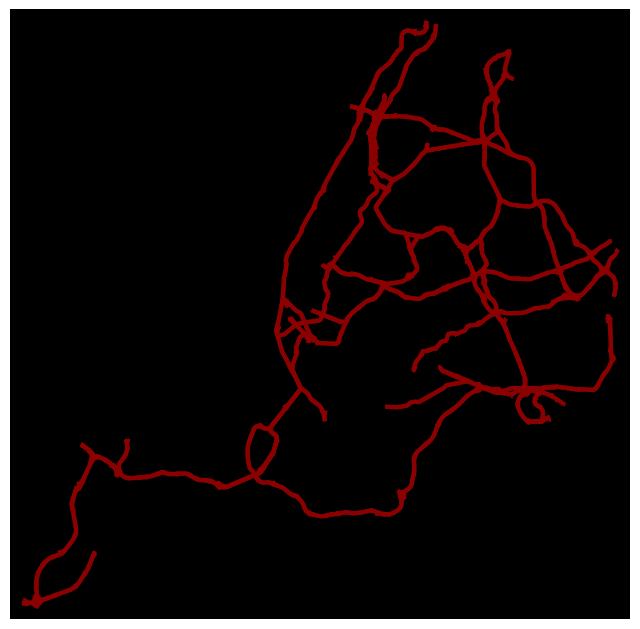

In [110]:
ox.settings.use_cache = True
ox.settings.log_console = True

# Define place and filter
place_name = "New York City, New York, USA"
custom_filter = '["highway"~"motorway|trunk"]'

# Get the graph using the updated approach
# First get the place boundary
gdf = ox.geocode_to_gdf(place_name)

# Then get the network within this boundary with the custom filter
G_highways = ox.graph_from_polygon(
    polygon=gdf.unary_union,  # Use the geometry from the geocoded area
    network_type='drive',
    custom_filter=custom_filter
)

# Plot the graph
fig, ax = ox.plot.plot_graph(G_highways, 
                           node_size=0,
                           node_color='darkred', 
                           edge_color='darkred',
                           edge_linewidth=3, 
                           bgcolor='black')

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_54607/18931226.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon=gdf.unary_union,  # Use the geometry from the geocoded area


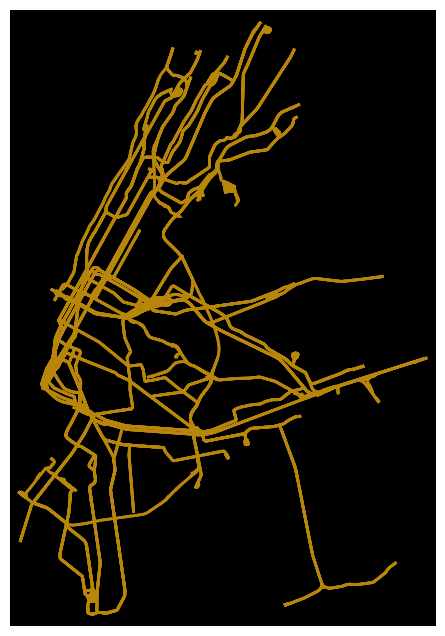

In [111]:
custom_filter = '["railway"~"subway|light_rail|rail"]'
place_name = "New York City, New York, USA"

# Get the graph using the updated approach
# First get the place boundary
gdf = ox.geocode_to_gdf(place_name)

# Then get the network within this boundary with the custom filter
G_rail = ox.graph_from_polygon(
    polygon=gdf.unary_union,  # Use the geometry from the geocoded area
    network_type='drive',
    custom_filter=custom_filter
)

# Plot the graph
fig, ax = ox.plot.plot_graph(G_rail, 
                           node_size=0,
                           node_color='blue', 
                           edge_color='darkgoldenrod',
                           edge_linewidth=2, 
                           bgcolor='black')

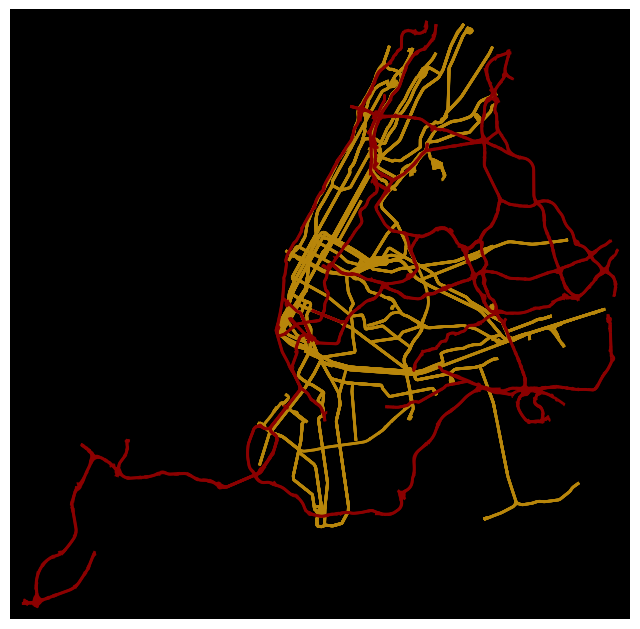

In [112]:
G = nx.compose(G_rail, G_highways)


ec = ['darkred' if 'highway' in d else 'darkgoldenrod' for _, _, _, d in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, bgcolor='black', edge_color=ec,
                        node_size=0, edge_linewidth=2,
                        show=False, close=False)

plt.show()

In [113]:
G_proj = ox.project_graph(G, to_crs='epsg:3857')
G_rail_proj = ox.project_graph(G_rail, to_crs='epsg:3857')
G_highways_proj = ox.project_graph(G_highways, to_crs='epsg:3857')

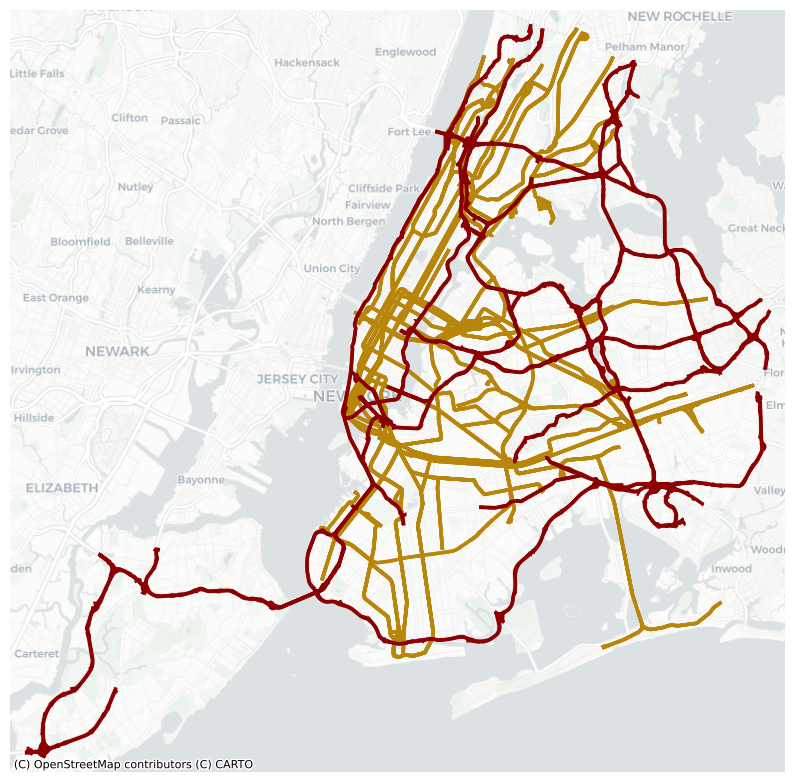

In [114]:
ec = ['darkred' if 'highway' in d else 'darkgoldenrod' for _, _, _, d in G_proj.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G_proj, bgcolor='white', edge_color=ec,
                        node_size=0, edge_linewidth=2.5,
                        show=False, close=False, figsize=(10,10))

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=G_proj.graph['crs'])

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

In [115]:
def graph_to_shape(graph_proj):
    edges = []
    for u, v, k, data in graph_proj.edges(keys=True, data=True):
        if 'geometry' in data:
            geom = data['geometry']
        else:
            # Create a straight LineString if geometry is missing
            point_u = (graph_proj.nodes[u]['x'], graph_proj.nodes[u]['y'])
            point_v = (graph_proj.nodes[v]['x'], graph_proj.nodes[v]['y'])
            geom = LineString([point_u, point_v])

        edges.append({
            'u': u,
            'v': v,
            'key': k,
            'geometry': geom,
            **data  # include other attributes
        })

    # Create GeoDataFrame
    edges_gdf = gpd.GeoDataFrame(edges, crs=graph_proj.graph['crs'])
    
    return edges_gdf

# Define Hex Grid

Total candidate hex cells: 252
Hex cells intersecting original polygon + buffer: 302


<Axes: >

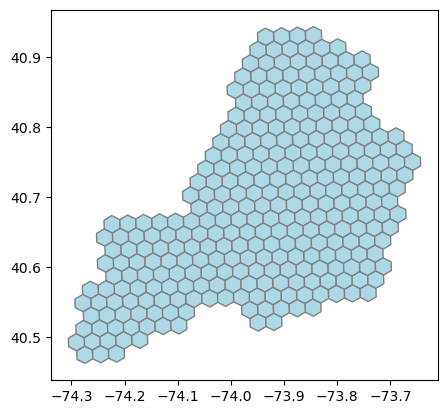

In [116]:
LatLngPoly = h3.LatLngPoly

# Load and combine NYC polygons
gdf = gpd.read_file("nyc_boroughs.geojson")
geometry = gdf.dissolve().geometry.values[0]

# Handle MultiPolygon or Polygon uniformly
polygons = geometry.geoms if geometry.geom_type == "MultiPolygon" else [geometry]

# Convert polygons to LatLngPoly for H3
latlng_polys = []
for poly in polygons:
    outer_ring = [[y, x] for x, y in poly.exterior.coords[:]]
    latlng_polys.append(h3.LatLngPoly(outer_ring))

# Collect all candidate H3 cells: base cells + neighbors
all_candidate_cells = set()
for shape in latlng_polys:
    base_cells = h3.polygon_to_cells(shape, res=7)
    candidate_cells = set(base_cells)
    for cell in base_cells:
        candidate_cells.update(h3.grid_ring(cell, 1))  # add neighbors (distance 1)
    all_candidate_cells.update(candidate_cells)

# Convert H3 cells to polygons for spatial filtering
polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in all_candidate_cells
]

# Create GeoDataFrame of candidate hex cells
candidate_gdf = gpd.GeoDataFrame(
    {'h3_index': list(all_candidate_cells), 'geometry': polygons},
    crs='EPSG:4326'
)

# Create GeoDataFrame for original geometry
geom_gdf = gpd.GeoDataFrame({'geometry': [geometry]}, crs='EPSG:4326')

# Filter hex cells intersecting the original polygon(s)
intersecting_hexes = candidate_gdf[candidate_gdf.geometry.intersects(geometry)]

# Add an extra ring of hexes around the current selection
core_hexes = set(intersecting_hexes['h3_index'])
buffer_hexes = set()
for h in core_hexes:
    buffer_hexes.update(h3.grid_ring(h, 1))
outer_ring_hexes = buffer_hexes - core_hexes

# Convert extra ring to geometries and add to intersecting_hexes
extra_polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in outer_ring_hexes
]
extra_gdf = gpd.GeoDataFrame(
    {'h3_index': list(outer_ring_hexes), 'geometry': extra_polygons},
    crs='EPSG:4326'
)
intersecting_hexes = pd.concat([intersecting_hexes, extra_gdf], ignore_index=True)

print(f"Total candidate hex cells: {len(all_candidate_cells)}")
print(f"Hex cells intersecting original polygon + buffer: {len(intersecting_hexes)}")

# Optional: Plot result
intersecting_hexes.plot(edgecolor='gray', facecolor='lightblue', figsize=(5,5))

In [117]:
def plot_df(df, column=None, ax=None):
    "Plot based on the `geometry` column of a GeoPandas dataframe"
    df = df.copy()
    df = df.to_crs(epsg=3857)  # web mercator

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'},
    )
    ctx.add_basemap(ax, crs=df.crs, source=ctx.providers.CartoDB.Positron)


def plot_shape(shape, ax=None):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)


def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)


def plot_shape_and_cells(shape, res=7):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

In [118]:
# Convert each H3 cell index in intersecting_hexes to a Shapely Polygon
polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in intersecting_hexes['h3_index']
]

# Create GeoDataFrame with same CRS
hex_gdf = gpd.GeoDataFrame(
    {'h3_index': intersecting_hexes['h3_index'], 'geometry': polygons},
    crs='EPSG:4326'
)

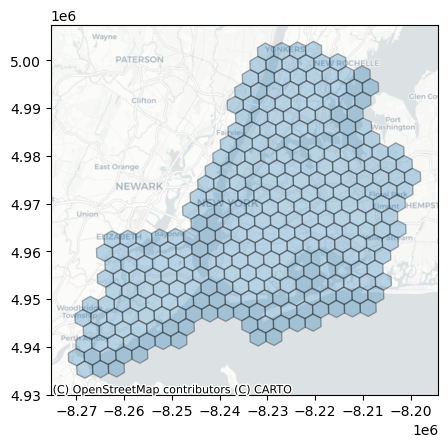

In [119]:
hex_gdf_proj = hex_gdf.to_crs(epsg=3857)

# Plot with background
ax = hex_gdf_proj.plot(figsize=(5, 5), alpha=0.3, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=hex_gdf_proj.crs)
# plt.show()

In [120]:
hex_gdf.head()

,h3_index,geometry
0,872a10624ffffff,"POLYGON ((-74.11885 40.65816, -74.13353 40.651..."
1,872a10768ffffff,"POLYGON ((-73.90696 40.59004, -73.92164 40.583..."
2,872a10752ffffff,"POLYGON ((-74.08745 40.62208, -74.10212 40.615..."
3,872a1005effffff,"POLYGON ((-73.74729 40.72353, -73.76204 40.716..."
4,872a10742ffffff,"POLYGON ((-74.01209 40.60569, -74.02677 40.599..."


In [121]:
len(hex_gdf)

302

# Combining the Grid and the Graph

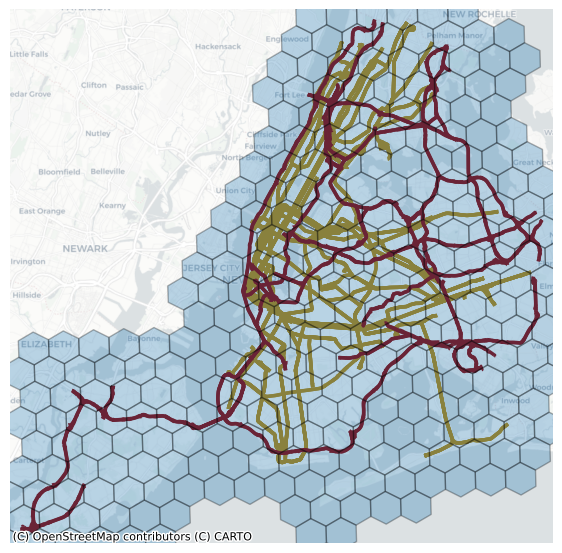

In [122]:
# Compute edge colors for plotting
ec = ['darkred' if 'highway' in d else 'darkgoldenrod' for _, _, _, d in G_proj.edges(keys=True, data=True)]

# Step 1: Plot the graph on a custom axis
fig, ax = ox.plot_graph(G_proj, bgcolor='white', edge_color=ec,
                        node_size=0, edge_linewidth=2.5,
                        show=False, close=False, figsize=(7,7))


# Step 3: Plot the GeoDataFrame on the same axis
hex_gdf_proj.plot(ax=ax, alpha=0.3, edgecolor='black')

# Step 4: Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=G_proj.graph['crs'])

# Step 5: Restore original axis limits
# xmin, xmax = ax.get_xlim()
# ymin, ymax = ax.get_ylim()
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

# Step 6: Show the figure
plt.show()

In [123]:
def get_hex_sides(hex_gdf_proj):
    hex_sides = []

    for idx, row in hex_gdf_proj.iterrows():
        polygon = row.geometry
        coords = list(polygon.exterior.coords)
        # create LineString for each side of the hexagon
        for i in range(len(coords) - 1):
            line = LineString([coords[i], coords[i+1]])
            hex_sides.append({'h3_index': row.h3_index, 'geometry': line})

    # Convert to GeoDataFrame
    sides_gdf = gpd.GeoDataFrame(hex_sides, crs=hex_gdf_proj.crs)
    
    return sides_gdf

sides_gdf = get_hex_sides(hex_gdf_proj)

In [124]:
def get_intersecting_sides(hex_gdf_proj, graph_proj):
    sides_gdf = get_hex_sides(hex_gdf_proj)
    edges_gdf = graph_to_shape(graph_proj)
    intersecting_sides = gpd.sjoin(sides_gdf, edges_gdf[['geometry']], how='inner', predicate='intersects')
    intersecting_sides = intersecting_sides.drop_duplicates(subset=['geometry'])
    
    return intersecting_sides

intersecting_sides = get_intersecting_sides(hex_gdf_proj, G_highways_proj)

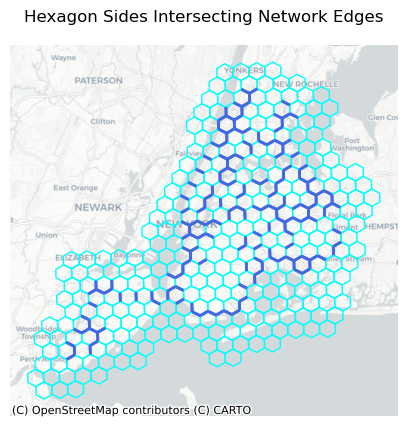

In [125]:
ax = hex_gdf_proj.plot(edgecolor='cyan', facecolor='none', figsize=(5, 5))
intersecting_sides.plot(ax=ax, color='royalblue', linewidth=2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=sides_gdf.crs)

plt.title("Hexagon Sides Intersecting Network Edges")
plt.axis('off')

plt.show()

In [126]:
hex_centroids = hex_gdf_proj.copy()
hex_centroids['centroid'] = hex_centroids.geometry.centroid
centroid_dict = hex_centroids.set_index('h3_index')['centroid'].to_dict()

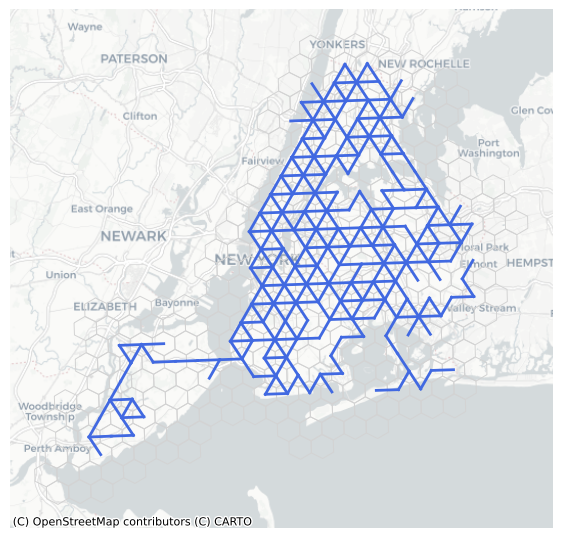

In [127]:
def create_hex_graph(hex_gdf_proj, G_base_proj, color='royalblue'):
    
    intersecting_sides = get_intersecting_sides(hex_gdf_proj, G_base_proj)
    
    
    # Compute centroids
    hex_centroids = hex_gdf_proj.copy()
    hex_centroids['centroid'] = hex_centroids.geometry.centroid
    centroid_dict = hex_centroids.set_index('h3_index')['centroid'].to_dict()

    # Initialize graph
    G_connected = nx.Graph()

    # Spatial index for efficiency
    sindex = hex_gdf_proj.sindex

    for _, row in intersecting_sides.iterrows():
        side_geom = row.geometry

        # Bounding box filter
        candidates = list(sindex.intersection(side_geom.bounds))
        touching_hexes = []

        for idx in candidates:
            hex_row = hex_gdf_proj.iloc[idx]
            if hex_row.geometry.touches(side_geom):
                intersection_geom = hex_row.geometry.intersection(side_geom)
                if intersection_geom.geom_type == 'LineString':
                    touching_hexes.append(hex_row['h3_index'])

        # Add edges only if two hexes share this exact side
        if len(touching_hexes) == 2:
            h1, h2 = touching_hexes
            if h1 in centroid_dict and h2 in centroid_dict:
                G_connected.add_edge(h1, h2)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(7, 7))
    hex_gdf_proj.boundary.plot(ax=ax, color='lightgray', linewidth=0.7)

    # Draw edges between centroids
    for u, v in G_connected.edges():
        x = [centroid_dict[u].x, centroid_dict[v].x]
        y = [centroid_dict[u].y, centroid_dict[v].y]
        ax.plot(x, y, color=color, linewidth=2)

    # Basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=hex_gdf_proj.crs)
    plt.axis('off')
    plt.show()

    return G_connected

G_connected = create_hex_graph(hex_gdf_proj, G_proj)

In [128]:
len(G_connected.nodes)

166

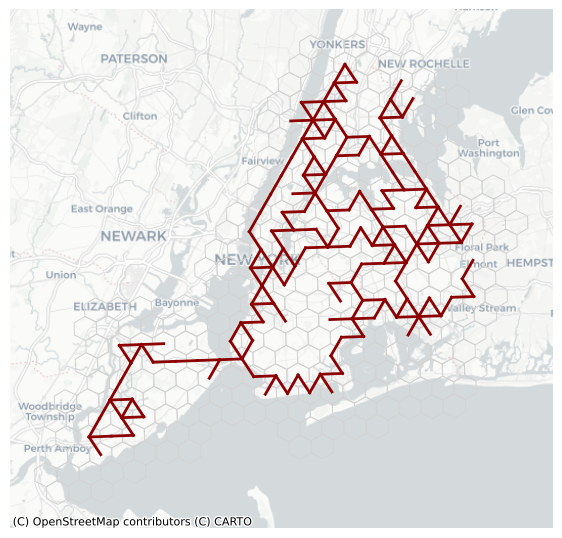

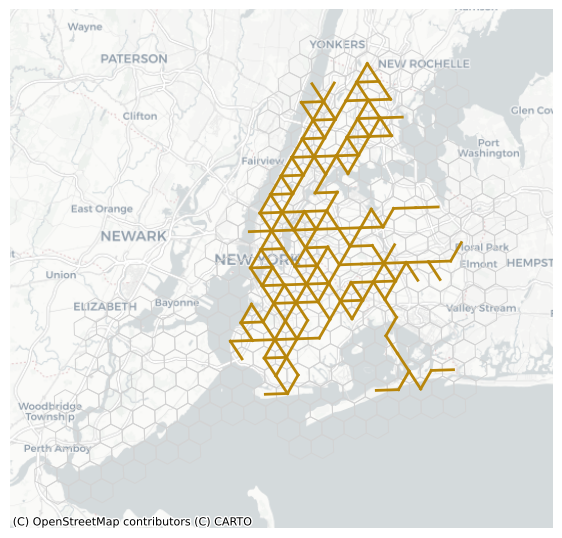

In [129]:
G_connected_highways = create_hex_graph(hex_gdf_proj, G_highways_proj, 'darkred')
G_connected_rail = create_hex_graph(hex_gdf_proj, G_rail_proj, 'darkgoldenrod')

In [130]:
for node in centroid_dict.keys():
    G_connected_highways.add_node(node)
    G_connected_rail.add_node(node)
    G_connected.add_node(node)

In [131]:
len(G_connected)

302

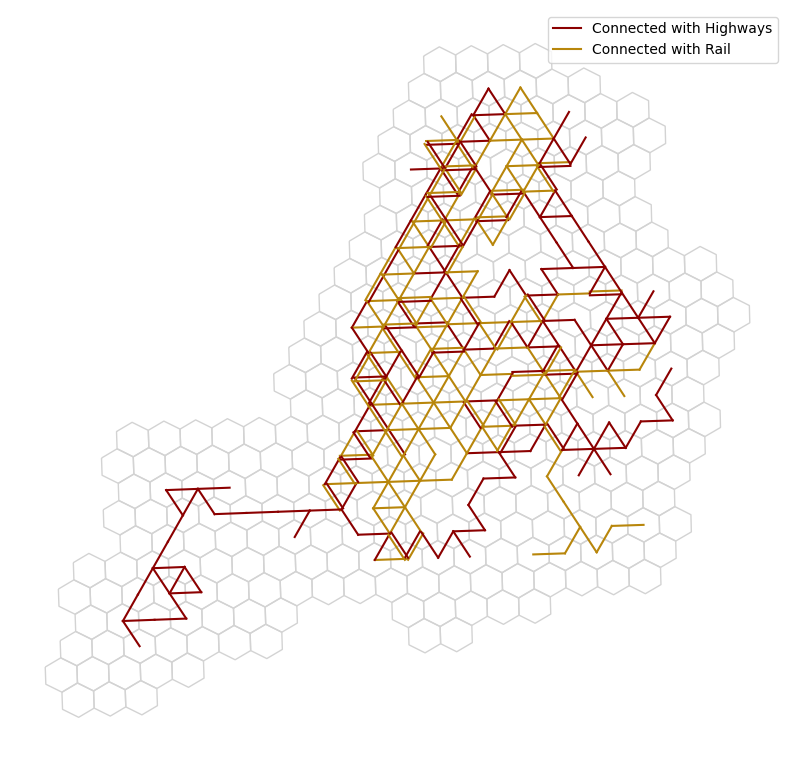

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot hexagon outlines
hex_gdf_proj.boundary.plot(ax=ax, color='lightgray', linewidth=1)

# Normalize edges as sorted tuples to ignore direction
def normalize_edges(G):
    return {tuple(sorted(edge)) for edge in G.edges()}

edges_1 = normalize_edges(G_connected_highways)
edges_2 = normalize_edges(G_connected_rail)
all_edges = edges_1.union(edges_2)

# Offset helper: returns coordinates of an edge shifted perpendicular by `offset`
def offset_coords(p1, p2, offset):
    dx, dy = p2.x - p1.x, p2.y - p1.y
    length = np.hypot(dx, dy)
    if length == 0:
        return [(p1.x, p1.y), (p2.x, p2.y)]
    ox, oy = -dy / length * offset, dx / length * offset
    return [(p1.x + ox, p1.y + oy), (p2.x + ox, p2.y + oy)]

for edge in all_edges:
    u, v = edge
    if u not in centroid_dict or v not in centroid_dict:
        continue

    p1, p2 = centroid_dict[u], centroid_dict[v]
    in_1 = edge in edges_1
    in_2 = edge in edges_2

    if in_1 and in_2:
        # Offset both ways to show side-by-side
        coords1 = offset_coords(p1, p2, offset=200)
        coords2 = offset_coords(p1, p2, offset=-200)
        ax.plot(*zip(*coords1), color='darkred', linewidth=1.5, label='Connected with Highways')
        ax.plot(*zip(*coords2), color='darkgoldenrod', linewidth=1.5, label='Connected with Rail')
    elif in_1:
        coords = offset_coords(p1, p2, offset=0)
        ax.plot(*zip(*coords), color='darkred', linewidth=1.5, label='Connected with Highways')
    elif in_2:
        coords = offset_coords(p1, p2, offset=0)
        ax.plot(*zip(*coords), color='darkgoldenrod', linewidth=1.5, label='Connected with Rail')

# Add basemap
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=hex_gdf_proj.crs)

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.axis('off')
plt.show()


In [133]:
def get_adj_matrix(connected_graph):
    nodes = sorted(connected_graph.nodes)

    adj_matrix = pd.DataFrame(0, index=nodes, columns=nodes, dtype=int)
    
    undirected_graph = connected_graph.to_undirected()

    for u, v in undirected_graph.edges:
        adj_matrix.at[u, v] = 1
        adj_matrix.at[v, u] = 1

    return adj_matrix

In [134]:
adj_mat_highways = get_adj_matrix(G_connected_highways)
adj_mat_rail = get_adj_matrix(G_connected_rail)
adj_mat_all = get_adj_matrix(G_connected)

In [135]:
adj_mat_all

,872a10000ffffff,872a10001ffffff,872a10002ffffff,872a10003ffffff,872a10004ffffff,872a10005ffffff,872a10006ffffff,872a10008ffffff,872a10009ffffff,872a1000affffff,...,872a1076cffffff,872a1076dffffff,872a1076effffff,872a10770ffffff,872a10771ffffff,872a10772ffffff,872a10773ffffff,872a10774ffffff,872a10775ffffff,872a10776ffffff
872a10000ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10001ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10002ffffff,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10003ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
872a10004ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872a10772ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
872a10773ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
872a10774ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
872a10775ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [139]:
def is_symmetric(df, tol=1e-8):
    return df.equals(df.T) or ((df - df.T).abs().max().max() < tol)

if is_symmetric(adj_mat_highways):
    print("The DataFrame is symmetric.")
else:
    print("The DataFrame is not symmetric.")


The DataFrame is symmetric.


In [140]:
adj_mat_all.to_csv('nyc_possibility_graph_adj_matrix_combined.csv')
adj_mat_highways.to_csv('nyc_possibility_graph_adj_matrix_highways.csv')
adj_mat_rail.to_csv('nyc_possibility_graph_adj_matrix_rail.csv')